Importing the useful libraries

In [100]:
# Importation of useful libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")


**1.1 Cleaning the data**

In [101]:
# Importing the database 
data = pd.read_csv("data.csv", encoding="ISO-8859-1", dtype={'CustomerID': str,'InvoiceID': str})

In [102]:
data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680,France


In [103]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  object 
 7   Country      541909 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 33.1+ MB


It appears that we can't replace the missing values and we can't keep data without the value in the customer id columns since we want to classify the customers. So I'll drop the lines with missing values on the customer ID column.

In [104]:
data = data.dropna(subset=["CustomerID"])
data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680,France


There are no more missing values.
I'll now check the dupplicate values and drop them if there's any. 

In [105]:
print('Duplicate entries: {}'.format(data.duplicated().sum()))
data.drop_duplicates(inplace = True)

Duplicate entries: 5225


**1.2 Exploratory Analysis**

This is very interesting since we can see various things here :
* The stock code values aren't only numerical, there are speciales values like D which means Discount 
* The InvoiceNo aren't also only numerical since there is a C before the other numbers for every negative value in the quantity column, this could mean that the order was canceled.

**1.2.3 InvoiceNo - Cancelation Code**

In [106]:
# Constucting a basket for later use
temp = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})

In [107]:
nb_products_per_basket.InvoiceNo = nb_products_per_basket.InvoiceNo.astype(str)
nb_products_per_basket['order_canceled'] = nb_products_per_basket['InvoiceNo'].apply(lambda x:int('C' in x))
len(nb_products_per_basket[nb_products_per_basket['order_canceled']==1])/len(nb_products_per_basket)*100

16.466876971608833

It appears that more than 16% of the transactions were canceled which is significant

By looking at these results, it appears that there is a counterpart to the canceled transaction in the database

In [108]:
test = data[data['Quantity'] < 0][['CustomerID','Quantity','StockCode','Description','UnitPrice']]
for index, col in  test.iterrows():
    if data[(data['CustomerID'] == col[0]) & (data['Quantity'] == -col[1]) 
                & (data['Description'] == col[2])].shape[0] == 0: 
        print(test.loc[index])
        break

CustomerID        14527
Quantity             -1
StockCode             D
Description    Discount
UnitPrice          27.5
Name: 141, dtype: object


In [109]:
data[data['CustomerID'] == '14527'].head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527,United Kingdom
8963,537159,22112,CHOCOLATE HOT WATER BOTTLE,6,12/5/2010 13:17,4.95,14527,United Kingdom
8964,537159,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/5/2010 13:17,4.95,14527,United Kingdom
8965,537159,21479,WHITE SKULL HOT WATER BOTTLE,1,12/5/2010 13:17,3.75,14527,United Kingdom
8966,537159,22114,HOT WATER BOTTLE TEA AND SYMPATHY,6,12/5/2010 13:17,3.95,14527,United Kingdom


It appears that when there is a discount there are no counterparts.
Let's try again but without the discount values

In [110]:
data_check = data[(data['Quantity'] < 0) & (data['Description'] != 'Discount')][
                                 ['CustomerID','Quantity','StockCode',
                                  'Description','UnitPrice']]

for index, col in  data_check.iterrows():
    if data[(data['CustomerID'] == col[0]) & (data['Quantity'] == -col[1]) 
                & (data['Description'] == col[2])].shape[0] == 0: 
        print(index, data_check.loc[index])
        break

154 CustomerID                               15311
Quantity                                    -1
StockCode                               35004C
Description    SET OF 3 COLOURED  FLYING DUCKS
UnitPrice                                 4.65
Name: 154, dtype: object


In [111]:
data[(data['CustomerID'] == '15311') & (data['Description'] == 'SET OF 3 COLOURED  FLYING DUCKS')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311,United Kingdom
9200,537195,35004C,SET OF 3 COLOURED FLYING DUCKS,12,12/5/2010 13:55,4.65,15311,United Kingdom
18196,C537805,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/8/2010 13:18,4.65,15311,United Kingdom
28630,538651,35004C,SET OF 3 COLOURED FLYING DUCKS,12,12/13/2010 15:07,4.65,15311,United Kingdom
39381,C539640,35004C,SET OF 3 COLOURED FLYING DUCKS,-3,12/20/2010 15:27,4.65,15311,United Kingdom
44157,540157,35004C,SET OF 3 COLOURED FLYING DUCKS,12,1/5/2011 11:41,4.65,15311,United Kingdom
59542,541293,35004C,SET OF 3 COLOURED FLYING DUCKS,12,1/17/2011 13:39,4.65,15311,United Kingdom
78333,C542866,35004C,SET OF 3 COLOURED FLYING DUCKS,-2,2/1/2011 12:14,4.65,15311,United Kingdom


In [113]:
df_cleaned = data.copy(deep = True)
df_cleaned['QuantityCanceled'] = 0

entry_to_remove = [] ; doubtful_entry = []

for index, col in  data.iterrows():
    if (col['Quantity'] > 0) or col['Description'] == 'Discount': continue        
    df_test = data[(data['CustomerID'] == col['CustomerID']) &
                         (data['StockCode']  == col['StockCode']) & 
                         (data['InvoiceDate'] < col['InvoiceDate']) & 
                         (data['Quantity']   > 0)].copy()
    #_________________________________
    # Cancelation WITHOUT counterpart
    if (df_test.shape[0] == 0): 
        doubtful_entry.append(index)
    #________________________________
    # Cancelation WITH a counterpart
    elif (df_test.shape[0] == 1): 
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'QuantityCanceled'] = -col['Quantity']
        entry_to_remove.append(index)        
    #______________________________________________________________
    # Various counterparts exist in orders: we delete the last one
    elif (df_test.shape[0] > 1): 
        df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']: continue
            df_cleaned.loc[ind, 'QuantityCanceled'] = -col['Quantity']
            entry_to_remove.append(index) 
            break    

In [114]:
print("entry_to_remove: {}".format(len(entry_to_remove)))
print("doubtful_entry: {}".format(len(doubtful_entry)))

entry_to_remove: 6151
doubtful_entry: 2607


In [115]:
df_cleaned.drop(entry_to_remove, axis = 0, inplace = True)
df_cleaned.drop(doubtful_entry, axis = 0, inplace = True)
remaining_entries = df_cleaned[(df_cleaned['Quantity'] < 0) & (df_cleaned['StockCode'] != 'D')]
print("number of entries to delete: {}".format(remaining_entries.shape[0]))
remaining_entries[:5]

number of entries to delete: 37


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
27329,C538530,22630,DOLLY GIRL LUNCH BOX,-33,12/13/2010 10:26,1.95,14796,United Kingdom,0
32870,C539195,22942,CHRISTMAS LIGHTS 10 SANTAS,-5,12/16/2010 12:05,8.50,12748,United Kingdom,0
33085,C539221,22941,CHRISTMAS LIGHTS 10 REINDEER,-12,12/16/2010 12:56,8.50,14911,EIRE,0
33086,C539221,22942,CHRISTMAS LIGHTS 10 SANTAS,-10,12/16/2010 12:56,8.50,14911,EIRE,0
77599,C542744,22700,BLACK AND WHITE DOG BOWL,-10,1/31/2011 16:32,0.85,16191,United Kingdom,0


In [116]:
df_cleaned.drop(remaining_entries.index, axis = 0, inplace = True)

It seels that the customer can also cancel just a part of the transaction which is logical so we need to take this into account for later.

**1.2.4 Stockcode**

These are specific operations which doesn't characterize our customers so I'll just drop these transactions from our database

In [117]:
list_special_codes = df_cleaned[df_cleaned['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
list_special_codes

array(['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT'],
      dtype=object)

In [118]:
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'POST']
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'D']
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'C2']
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'M']
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'BANK CHARGES']
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'PADS']
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'DOT']

In [119]:
df_cleaned.describe()

,Quantity,UnitPrice,QuantityCanceled
count,391183.000000,391183.000000,391183.000000
mean,13.179665,2.874130,0.583911
std,181.907403,4.284639,175.868790
min,1.000000,0.000000,0.000000
25%,2.000000,1.250000,0.000000
50%,6.000000,1.950000,0.000000
75%,12.000000,3.750000,0.000000
max,80995.000000,649.500000,80995.000000


In [121]:
df_cleaned[(df_cleaned['UnitPrice'] == 0)].head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
9302,537197,22841,ROUND CAKE TIN VINTAGE GREEN,1,12/5/2010 14:02,0.0,12647,Germany,0
33576,539263,22580,ADVENT CALENDAR GINGHAM SACK,4,12/16/2010 14:36,0.0,16560,United Kingdom,0
40089,539722,22423,REGENCY CAKESTAND 3 TIER,10,12/21/2010 13:45,0.0,14911,EIRE,0
47068,540372,22090,PAPER BUNTING RETROSPOT,24,1/6/2011 16:41,0.0,13081,United Kingdom,0
47070,540372,22553,PLASTERS IN TIN SKULLS,24,1/6/2011 16:41,0.0,13081,United Kingdom,0


In [ ]:
df_cleaned = df_cleaned[(df_cleaned['UnitPrice'] != 0)]

In [ ]:
# Total price feature

df_cleaned['TotalPrice'] = df_cleaned['UnitPrice'] * (df_cleaned['Quantity'] - df_cleaned['QuantityCanceled'])

In [ ]:
basket = df_cleaned.groupby(['CustomerID']).agg({'StockCode': lambda s: list(set(s))}) # grouping product from the same invoice. 
basket

,StockCode
CustomerID,
12346,[23166]
12347,"[22196, 23170, 22131, 21041, 84969, 47559B, 47..."
12348,"[21977, 23076, 21967, 21213, 22616, 22951, 219..."
12349,"[22567, 22195, 37500, 23497, 23283, 22554, 224..."
12350,"[21832, 79066K, 79191C, 21915, 84086C, 22412, ..."
...,...
18280,"[22180, 22499, 82484, 22727, 22725, 22467, 220..."
18281,"[23008, 23007, 22467, 22028, 22716, 23209, 22037]"
18282,"[22818, 22423, 21270, 21109, 23175, 23174, 220..."


In [ ]:
basket.to_csv('basket.csv')

In [ ]:
df_cleaned

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom,0,15.30
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom,0,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom,0,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom,0,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom,0,20.34
...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680,France,0,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680,France,0,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680,France,0,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680,France,0,16.60


In [ ]:
df_cleaned.to_csv('cleaned_data.csv')

**1.3 RFM**

In [122]:
rfm_data = pd.read_csv("cleaned_data.csv", encoding="ISO-8859-1")
rfm_data['CustomerID'] = rfm_data['CustomerID'].astype(int)
rfm_data['InvoiceDate'] = rfm_data['InvoiceDate'].astype('datetime64')
NOW = rfm_data['InvoiceDate'].max()


In [123]:
custom_aggregation = {}
custom_aggregation["InvoiceDate"] = lambda x:x.iloc[0]
custom_aggregation["CustomerID"] = lambda x:x.iloc[0]
custom_aggregation["TotalPrice"] = "sum"


rfmTable = rfm_data.groupby("InvoiceNo").agg(custom_aggregation)

In [124]:
rfmTable["Recency"] = NOW - rfmTable["InvoiceDate"]
rfmTable["Recency"] = pd.to_timedelta(rfmTable["Recency"]).astype("timedelta64[D]")

In [125]:
custom_aggregation = {}

custom_aggregation["Recency"] = ["min", "max"]
custom_aggregation["InvoiceDate"] = lambda x: len(x)
custom_aggregation["TotalPrice"] = "sum"

rfmTable_final = rfmTable.groupby("CustomerID").agg(custom_aggregation)

In [126]:
rfmTable_final.columns = ["min_recency", "max_recency", "frequency", "monetary value"]

In [127]:
rfmTable_final

,min_recency,max_recency,frequency,monetary value
CustomerID,,,,
12346,325.0,325.0,1,0.00
12347,1.0,366.0,7,4310.00
12348,74.0,357.0,4,1437.24
12349,18.0,18.0,1,1457.55
12350,309.0,309.0,1,294.40
...,...,...,...,...
18280,277.0,277.0,1,180.60
18281,180.0,180.0,1,80.82
18282,7.0,125.0,2,176.60


In [128]:
rfmTable_final['recency'] = rfmTable_final['max_recency'] - rfmTable_final['min_recency']
rfmTable_final 

,min_recency,max_recency,frequency,monetary value,recency
CustomerID,,,,,
12346,325.0,325.0,1,0.00,0.0
12347,1.0,366.0,7,4310.00,365.0
12348,74.0,357.0,4,1437.24,283.0
12349,18.0,18.0,1,1457.55,0.0
12350,309.0,309.0,1,294.40,0.0
...,...,...,...,...,...
18280,277.0,277.0,1,180.60,0.0
18281,180.0,180.0,1,80.82,0.0
18282,7.0,125.0,2,176.60,118.0


In [129]:
rfm_final = rfmTable_final[['recency', 'frequency', 'monetary value']]
rfm_final

,recency,frequency,monetary value
CustomerID,,,
12346,0.0,1,0.00
12347,365.0,7,4310.00
12348,283.0,4,1437.24
12349,0.0,1,1457.55
12350,0.0,1,294.40
...,...,...,...
18280,0.0,1,180.60
18281,0.0,1,80.82
18282,118.0,2,176.60


In [130]:
rfm_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4334 entries, 12346 to 18287
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   recency         4334 non-null   float64
 1   frequency       4334 non-null   int64  
 2   monetary value  4334 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 135.4 KB


In [ ]:
rfm_final.to_csv('rfm_final.csv')

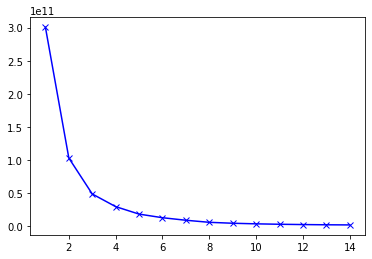

In [ ]:
#Find most suitable number of clusters
sum_distances = []
K = range(1,15)
for k in K:
  k_mean = KMeans(n_clusters=k)
  k_mean.fit(rfm_final)
  sum_distances.append(k_mean.inertia_)

plt.plot(K, sum_distances, 'bx-')
plt.show()

This graph is the Elbow method and based on that, k from 2 to 4 may optimal

#### Check with the Silhouette Method and Calinski Harabasz to find optimal K

In [ ]:
for k in range(2, 5):
    k_mean_k = KMeans(n_clusters=k)
    model = k_mean_k.fit(rfm_final)
    result = k_mean_k.labels_
    print('Silhouette score for', k, 'cluster: ',metrics.silhouette_score(rfm_final, result, metric='euclidean'))
    print('Calinski Harabasz score for', k, 'cluster: ',metrics.calinski_harabasz_score(rfm_final, result))

Silhouette score for 2 cluster:  0.9863671162300737
Calinski Harabasz score for 2 cluster:  8348.107832593774
Silhouette score for 3 cluster:  0.9631162212161485
Calinski Harabasz score for 3 cluster:  11315.60992681182
Silhouette score for 4 cluster:  0.8840822604035335
Calinski Harabasz score for 4 cluster:  13450.809748726744


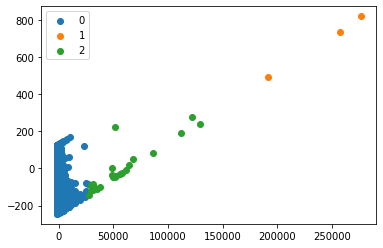

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(2)
 
#Transform the data
df = pca.fit_transform(rfm_final)
 
#Import KMeans module
from sklearn.cluster import KMeans
 
#Initialize the class object
kmeans = KMeans(n_clusters= 3)
 
#predict the labels of clusters.
label = kmeans.fit_predict(df)
 
#Getting unique labels
u_labels = np.unique(label)
 
#plotting the results:
for i in u_labels:
    plt.scatter(df[label == i , 0] , df[label == i , 1] , label = i)
plt.legend()
plt.show()

In [ ]:
km = KMeans(n_clusters=3)
y_predict = km.fit_predict(rfm_final[['frequency', 'monetary value']]) 
y_predict

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [ ]:
rfm_final['cluster']=y_predict
rfm_final

,recency,frequency,monetary value,cluster
CustomerID,,,,
12346,0.0,1,0.00,0
12347,365.0,7,4310.00,0
12348,283.0,4,1437.24,0
12349,0.0,1,1457.55,0
12350,0.0,1,294.40,0
...,...,...,...,...
18280,0.0,1,180.60,0
18281,0.0,1,80.82,0
18282,118.0,2,176.60,0


In [ ]:
rfm_final["cluster"].value_counts()

0    4307
2      24
1       3
Name: cluster, dtype: int64

### We scale rfm

In [ ]:
from sklearn.preprocessing import StandardScaler
rfm_data_scale = StandardScaler()
rfm_data_scale = rfm_data_scale.fit_transform(rfm_final) 
rfm_data_scale = rfm_data_scale.tolist()

df_rfm_data_scale = pd.DataFrame (rfm_data_scale, columns = ['recency', 'frequency', 'monetary value'])
df_rfm_data_scale

,recency,frequency,monetary value
0,-0.987601,-0.425192,-0.229930
1,1.772371,0.360754,0.287679
2,1.152323,-0.032219,-0.057325
3,-0.987601,-0.425192,-0.054885
4,-0.987601,-0.425192,-0.194574
...,...,...,...
4329,-0.987601,-0.425192,-0.208241
4330,-0.987601,-0.425192,-0.220224
4331,-0.095336,-0.294201,-0.208721
4332,1.530401,1.539674,0.015013


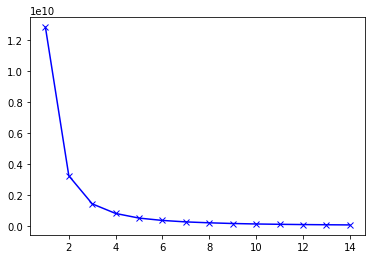

In [ ]:
#Find most suitable number of clusters
sum_distances = []
K = range(1,15)
for k in K:
  k_mean = KMeans(n_clusters=k)
  k_mean.fit(df_rfm_data_scale)
  sum_distances.append(k_mean.inertia_)

plt.plot(K, sum_distances, 'bx-')
plt.show()

In [ ]:
for k in range(2, 5):
    k_mean_k = KMeans(n_clusters=k)
    model = k_mean_k.fit(df_rfm_data_scale)
    result = k_mean_k.labels_
    print('Silhouette score for', k, 'cluster: ',metrics.silhouette_score(df_rfm_data_scale, result, metric='euclidean'))
    print('Calinski Harabasz score for', k, 'cluster: ',metrics.calinski_harabasz_score(df_rfm_data_scale, result))

Silhouette score for 2 cluster:  0.6238393254543169
Calinski Harabasz score for 2 cluster:  12838.825187745173
Silhouette score for 3 cluster:  0.5908188728795639
Calinski Harabasz score for 3 cluster:  17342.135416034867
Silhouette score for 4 cluster:  0.5706354841949581
Calinski Harabasz score for 4 cluster:  21568.483167975213


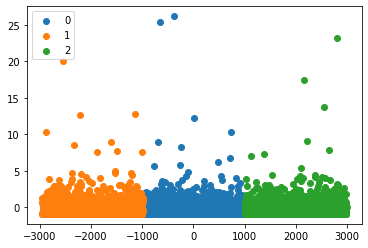

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(2)
 
#Transform the data
df = pca.fit_transform(df_rfm_data_scale)
 
#Import KMeans module
from sklearn.cluster import KMeans
 
#Initialize the class object
kmeans = KMeans(n_clusters= 3)
 
#predict the labels of clusters.
label = kmeans.fit_predict(df)
 
#Getting unique labels
u_labels = np.unique(label)
 
#plotting the results:
for i in u_labels:
    plt.scatter(df[label == i , 0] , df[label == i , 1] , label = i)
plt.legend()
plt.show()

In [ ]:
km = KMeans(n_clusters=3)
y_predicted = km.fit_predict(df_rfm_data_scale[['frequency', 'monetary value']]) 
y_predicted

array([0, 0, 0, ..., 0, 2, 0], dtype=int32)

In [ ]:
df_rfm_data_scale['cluster']=y_predicted
df_rfm_data_scale

,recency,frequency,monetary value,CustomerID,cluster
0,-0.987601,-0.425192,-0.229930,12346,0
1,1.772371,0.360754,0.287679,12347,0
2,1.152323,-0.032219,-0.057325,12348,0
3,-0.987601,-0.425192,-0.054885,12349,0
4,-0.987601,-0.425192,-0.194574,12350,0
...,...,...,...,...,...
4329,-0.987601,-0.425192,-0.208241,18280,0
4330,-0.987601,-0.425192,-0.220224,18281,0
4331,-0.095336,-0.294201,-0.208721,18282,0
4332,1.530401,1.539674,0.015013,18283,2


In [ ]:
df_rfm_data_scale["cluster"].value_counts()

0    4115
2     207
1      12
Name: cluster, dtype: int64

In [ ]:
rfm_data1 =df_rfm_data_scale[y_predicted==0]
rfm_data2 =df_rfm_data_scale[y_predicted==1]
rfm_data3 =df_rfm_data_scale[y_predicted==2]

In [ ]:
rfm_final

,recency,frequency,monetary value
CustomerID,,,
12346,0.0,1,0.00
12347,365.0,7,4310.00
12348,283.0,4,1437.24
12349,0.0,1,1457.55
12350,0.0,1,294.40
...,...,...,...
18280,0.0,1,180.60
18281,0.0,1,80.82
18282,118.0,2,176.60


### DBSCAN

In [ ]:
df_rfm_data_scale

,recency,frequency,monetary value
0,-0.987601,-0.425192,-0.229930
1,1.772371,0.360754,0.287679
2,1.152323,-0.032219,-0.057325
3,-0.987601,-0.425192,-0.054885
4,-0.987601,-0.425192,-0.194574
...,...,...,...
4329,-0.987601,-0.425192,-0.208241
4330,-0.987601,-0.425192,-0.220224
4331,-0.095336,-0.294201,-0.208721
4332,1.530401,1.539674,0.015013


In [ ]:
from sklearn.cluster import DBSCAN
x=df_rfm_data_scale.iloc[:,0:3].values
x

array([[-0.98760132, -0.42519207, -0.22992981],
       [ 1.77237149,  0.36075437,  0.28767923],
       [ 1.1523228 , -0.03221885, -0.05732461],
       ...,
       [-0.09533614, -0.294201  , -0.20872105],
       [ 1.53040127,  1.53967404,  0.01501336],
       [ 0.2146882 , -0.16320992, -0.00928184]])

In [ ]:
x.shape

(4334, 3)

In [ ]:
scaler = StandardScaler()
scaled_X = scaler.fit_transform(rfm_final) 
scaled_X

array([[-0.98760132, -0.42519207, -0.22992981],
       [ 1.77237149,  0.36075437,  0.28767923],
       [ 1.1523228 , -0.03221885, -0.05732461],
       ...,
       [-0.09533614, -0.294201  , -0.20872105],
       [ 1.53040127,  1.53967404,  0.01501336],
       [ 0.2146882 , -0.16320992, -0.00928184]])

In [ ]:
number_of_outliers=[]
percentage_of_outliers=[]
#min_samples starting point:2*no.of dimension
min_samples = 2 * scaled_X.shape[1]
for eps in np.linspace(0.001, 3, 50):
   #model creation
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan.fit(scaled_X)
   #Number of clusters
    number_of_outliers.append(np.sum(dbscan.labels_ == -1))
   #Percentage of points classified as outliers
    perc_outliers=100*np.sum(dbscan.labels_==-1) / len(dbscan.labels_)
    percentage_of_outliers.append (perc_outliers)

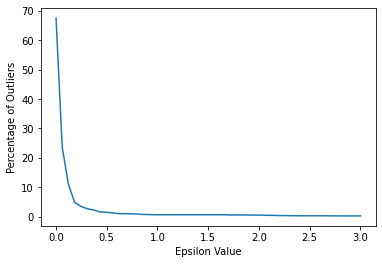

In [ ]:
sns.lineplot(x=np.linspace(0.001, 3, 50), y=percentage_of_outliers);
plt.xlabel('Epsilon Value')
plt.ylabel('Percentage of Outliers');

In [ ]:
min_samples=2*scaled_X.shape[1]
dbscan = DBSCAN(eps=0.15, min_samples=min_samples) 

In [ ]:
dbscan.fit(scaled_X)

DBSCAN(eps=0.15, min_samples=6)

In [ ]:
db=DBSCAN(eps=0.15,min_samples=6,metric='euclidean')

In [ ]:
model=db.fit(x)

In [ ]:
label=model.labels_

In [ ]:
label

array([ 0,  0,  0, ...,  0, -1,  0])

In [ ]:
from sklearn import metrics

#identifying the points which makes up our core points
sample_cores=np.zeros_like(label,dtype=bool)

sample_cores[db.core_sample_indices_]=True

#Calculating the number of clusters

n_clusters=len(set(label))- (1 if -1 in label else 0)
print('No of clusters:',n_clusters)

No of clusters: 3


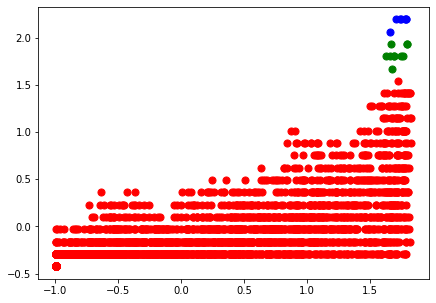

In [ ]:
y_means = db.fit_predict(x)
plt.figure(figsize=(7,5))
plt.scatter(x[y_means == 0, 0], x[y_means == 0, 1], s = 50, c = 'red')
plt.scatter(x[y_means == 1, 0], x[y_means == 1, 1], s = 50, c = 'green')
plt.scatter(x[y_means == 2, 0], x[y_means == 2, 1], s = 50, c = 'blue')
plt.show()